# OMSCS CS7641
# Machine Learning
# Allan Hammer
# Project 4

### Why?
In some sense, we have spent the semester thinking about machine learning techniques for various forms of function approximation. It's now time to think about using what we've learned in order to allow an agent of some kind to act in the world more directly. This assignment asks you to consider the application of some of the techniques we've learned from reinforcement learning to make decisions.

The same ground rules apply for programming languages as with the previous assignments.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import hiive.mdptoolbox.mdp
import hiive.mdptoolbox.openai as openai_
from gym.envs.toy_text.frozen_lake import generate_random_map
import gym
import time
import scipy.sparse as sp
warnings.filterwarnings("ignore")

## 1) MDPs
Come up with two interesting MDPs. Explain why they are interesting. They don't need to be overly complicated or directly grounded in a real situation, but it will be worthwhile if your MDPs are inspired by some process you are interested in or are familiar with. It's ok to keep it somewhat simple. For the purposes of this assignment, though, make sure one has a "small" number of states, and the other has a "large" number of states. I'm not going to go into detail about what large is, but 200 is not large. Furthermore, because I like variety no more than one of the MDPs you choose should be a so-called grid world problem.

### Chosen MDPs:
* Forest (small states, non-grid)
* Frozen Lake (large states, grid)

In [2]:
def forest(S=50, r1=4, r2=2, p=0.1, is_sparse=False):
    """Generate a MDP example based on a simple forest management scenario.
    This function is used to generate a transition probability
    (``A`` × ``S`` × ``S``) array ``P`` and a reward (``S`` × ``A``) matrix
    ``R`` that model the following problem. A forest is managed by two actions:
    'Wait' and 'Cut'. An action is decided each year with first the objective
    to maintain an old forest for wildlife and second to make money selling cut
    wood. Each year there is a probability ``p`` that a fire burns the forest.
    Here is how the problem is modelled.
    Let {0, 1 . . . ``S``-1 } be the states of the forest, with ``S``-1 being
    the oldest. Let 'Wait' be action 0 and 'Cut' be action 1.
    After a fire, the forest is in the youngest state, that is state 0.
    The transition matrix ``P`` of the problem can then be defined as follows::
                   | p 1-p 0.......0  |
                   | .  0 1-p 0....0  |
        P[0,:,:] = | .  .  0  .       |
                   | .  .        .    |
                   | .  .         1-p |
                   | p  0  0....0 1-p |
                   | 1 0..........0 |
                   | . .          . |
        P[1,:,:] = | . .          . |
                   | . .          . |
                   | . .          . |
                   | 1 0..........0 |
    The reward matrix R is defined as follows::
                 |  0  |
                 |  .  |
        R[:,0] = |  .  |
                 |  .  |
                 |  0  |
                 |  r1 |
                 |  0  |
                 |  1  |
        R[:,1] = |  .  |
                 |  .  |
                 |  1  |
                 |  r2 |
    Parameters
    ---------
    S : int, optional
        The number of states, which should be an integer greater than 1.
        Default: 3.
    r1 : float, optional
        The reward when the forest is in its oldest state and action 'Wait' is
        performed. Default: 4.
    r2 : float, optional
        The reward when the forest is in its oldest state and action 'Cut' is
        performed. Default: 2.
    p : float, optional
        The probability of wild fire occurence, in the range ]0, 1[. Default:
        0.1.
    is_sparse : bool, optional
        If True, then the probability transition matrices will be returned in
        sparse format, otherwise they will be in dense format. Default: False.
    Returns
    -------
    out : tuple
        ``out[0]`` contains the transition probability matrix P  and ``out[1]``
        contains the reward matrix R. If ``is_sparse=False`` then P is a numpy
        array with a shape of ``(A, S, S)`` and R is a numpy array with a shape
        of ``(S, A)``. If ``is_sparse=True`` then P is a tuple of length ``A``
        where each ``P[a]`` is a scipy sparse CSR format matrix of shape
        ``(S, S)``; R remains the same as in the case of ``is_sparse=False``.
    Examples
    --------
    >>> import hiive.mdptoolbox.example
    >>> P, R = hiive.mdptoolbox.example.forest()
    >>> P
    array([[[ 0.1,  0.9,  0. ],
            [ 0.1,  0. ,  0.9],
            [ 0.1,  0. ,  0.9]],
    <BLANKLINE>
           [[ 1. ,  0. ,  0. ],
            [ 1. ,  0. ,  0. ],
            [ 1. ,  0. ,  0. ]]])
    >>> R
    array([[ 0.,  0.],
           [ 0.,  1.],
           [ 4.,  2.]])
    >>> Psp, Rsp = hiive.mdptoolbox.example.forest(is_sparse=True)
    >>> len(Psp)
    2
    >>> Psp[0]
    <3x3 sparse matrix of type '<... 'numpy.float64'>'
        with 6 stored elements in Compressed Sparse Row format>
    >>> Psp[1]
    <3x3 sparse matrix of type '<... 'numpy.int64'>'
        with 3 stored elements in Compressed Sparse Row format>
    >>> Rsp
    array([[ 0.,  0.],
           [ 0.,  1.],
           [ 4.,  2.]])
    >>> (Psp[0].todense() == P[0]).all()
    True
    >>> (Rsp == R).all()
    True
    """
    assert S > 1, "The number of states S must be greater than 1."
    assert (r1 > 0) and (r2 > 0), "The rewards must be non-negative."
    assert 0 <= p <= 1, "The probability p must be in [0; 1]."
    # Definition of Transition matrix
    if is_sparse:
        P = []
        rows = list(range(S)) * 2
        cols = [0] * S + list(range(1, S)) + [S - 1]
        vals = [p] * S + [1-p] * S
        P.append(sp.coo_matrix((vals, (rows, cols)), shape=(S, S)).tocsr())
        rows = list(range(S))
        cols = [0] * S
        vals = [1] * S
        P.append(sp.coo_matrix((vals, (rows, cols)), shape=(S, S)).tocsr())
    else:
        P = np.zeros((2, S, S))
        P[0, :, :] = (1 - p) * np.diag(np.ones(S - 1), 1)
        P[0, :, 0] = p
        P[0, S - 1, S - 1] = (1 - p)
        P[1, :, :] = np.zeros((S, S))
        P[1, :, 0] = 1
    # Definition of Reward matrix
    R = np.zeros((S, 2))
    R[S - 1, 0] = r1
    R[:, 1] = np.ones(S)
    R[0, 1] = 0
    R[S - 1, 1] = r2
    return(P, R)

In [3]:
def openai(env_name:str, render:bool=False, **kwargs):
    """
    Generate a MDPToolbox-formatted version of a *discrete* OpenAI Gym environment. 
    You can find the list of available gym environments here: https://gym.openai.com/envs/#classic_control
    You'll have to look at the source code of the environments for available kwargs; as it is not well documented.  
    This function is used to generate a transition probability
    (``A`` × ``S`` × ``S``) array ``P`` and a reward (``S`` × ``A``) matrix
    ``R``.
    Parameters
    ---------
    env_name : str
        The name of the Open AI gym environment to model. 
    render : bool 
        Flag to render the environment via gym's `render()` function. 
    
    Returns
    -------
    out : tuple
        ``out[0]`` contains the transition probability matrix P  and ``out[1]``
        contains the reward matrix R. 
    Examples
    --------
    >>> import hiive.mdptoolbox.example
    >>> from gym.envs.toy_text.frozen_lake import generate_random_map
    >>> random_map = generate_random_map(size=10, p=0.98)
    >>> P, R = hiive.mdptoolbox.example.openai("FrozenLake-v0", desc=random_map)
    >>> P
    array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
    <BLANKLINE> 
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]])
    >>> R
    array([[ -1.,  -1.,  -1.,  -1.,  -1., -10.],
       [ -1.,  -1.,  -1.,  -1.,  -1., -10.],
       [ -1.,  -1.,  -1.,  -1.,  -1., -10.],
       ...,
       [ -1.,  -1.,  -1.,  -1., -10., -10.],
       [ -1.,  -1.,  -1.,  -1., -10., -10.],
       [ -1.,  -1.,  -1.,  -1., -10., -10.]])
    >>> P, R = hiive.mdptoolbox.example.openai("Taxi-v3", True)
    +---------+
    |R: | : :G|
    | : | : : |
    | : : : : |
    | | : | : |
    |Y| : |B: |
    +---------+`
    """

    env = openai_.OpenAI_MDPToolbox(env_name, render, **kwargs)
    return env.P, env.R

## 2) Solving
Solve each MDP using value iteration as well as policy iteration. How many iterations does it take to converge? Which one converges faster? Why? How did you choose to define convergence? Do they converge to the same answer? How did the number of states affect things, if at all?

In [4]:
discounts = [0.9, 0.95, 0.99]

### Forest Solving (Small state problem of 50 states, non-grid problem)

In [5]:
# example of waiting
P, R = forest(S=25)
vi = hiive.mdptoolbox.mdp.ValueIteration(P, R, 0.99)
vi.run()
policy = list(vi.policy)
values = list(vi.V)
policy

[0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



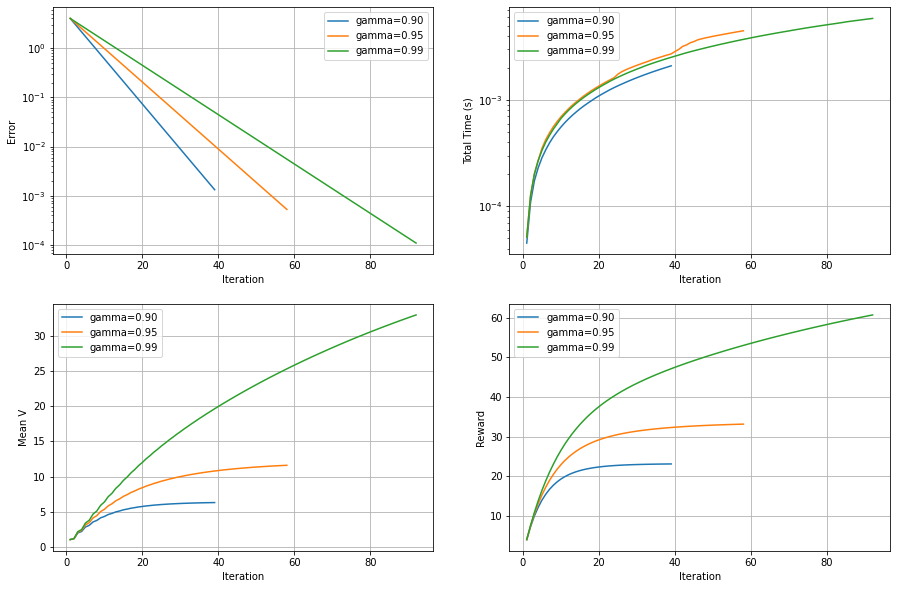

In [6]:
# Value Iteration
_, ax = plt.subplots(2, 2, figsize=(15, 10))

for i in range(3):
    P, R = forest()
    vi = hiive.mdptoolbox.mdp.ValueIteration(P, R, discounts[i])
    vi.run()

    policy = list(vi.policy)
    print(policy)
    print()
    
    gamma = discounts[i]

    ax[0][0].semilogy(range(1, vi.iter + 1), [run['Error'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[0][0].set_xlabel('Iteration')
    ax[0][0].set_ylabel('Error')
    ax[0][0].grid()
    ax[0][0].legend()

    ax[0][1].semilogy(range(1, vi.iter + 1), [run['Time'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[0][1].set_xlabel('Iteration')
    ax[0][1].set_ylabel('Total Time (s)')
    ax[0][1].grid()
    ax[0][1].legend()

    ax[1][0].plot(range(1, vi.iter + 1), [run['Mean V'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][0].set_xlabel('Iteration')
    ax[1][0].set_ylabel('Mean V')
    ax[1][0].grid()
    ax[1][0].legend()

    ax[1][1].plot(range(1, vi.iter + 1), [run['Reward'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][1].set_xlabel('Iteration')
    ax[1][1].set_ylabel('Reward')
    ax[1][1].grid()
    ax[1][1].legend()
    
plt.show()

In [7]:
print("Total Time to Implement in Seconds:", vi.time)
print("Total Iterations to Implement:", vi.iter)

Total Time to Implement in Seconds: 0.0058901309967041016
Total Iterations to Implement: 92


[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



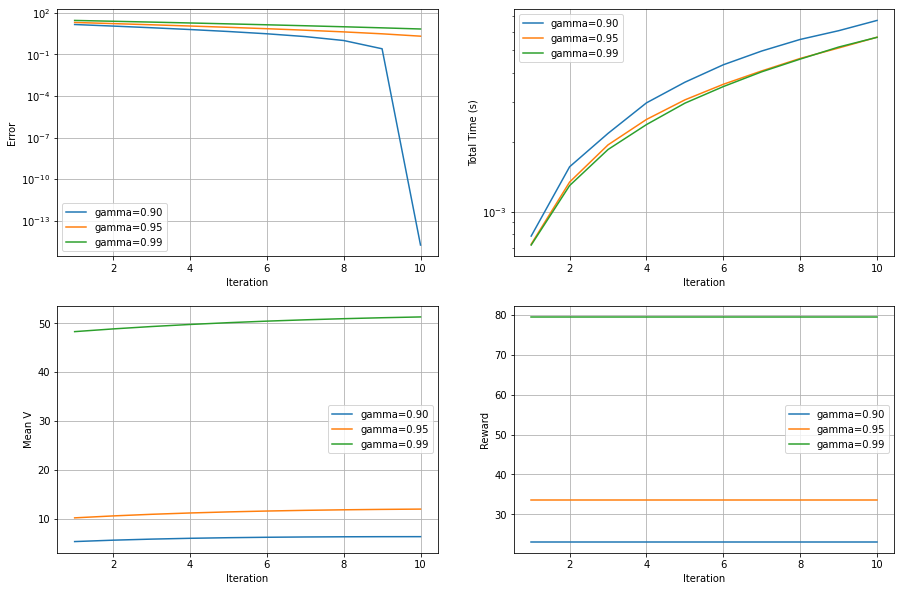

In [8]:
# Policy Iteration
_, ax = plt.subplots(2, 2, figsize=(15, 10))

for i in range(3):
    P, R = forest()
    pi = hiive.mdptoolbox.mdp.PolicyIteration(P, R, discounts[i], max_iter=10)
    pi.run()

    policy = list(vi.policy)
    print(policy)
    print()
    
    gamma = discounts[i]

    ax[0][0].semilogy(range(1, pi.iter + 1), [run['Error'] for run in pi.run_stats], label="gamma=%.2f" % gamma)
    ax[0][0].set_xlabel('Iteration')
    ax[0][0].set_ylabel('Error')
    ax[0][0].grid()
    ax[0][0].legend()

    ax[0][1].semilogy(range(1, pi.iter + 1), [run['Time'] for run in pi.run_stats], label="gamma=%.2f" % gamma)
    ax[0][1].set_xlabel('Iteration')
    ax[0][1].set_ylabel('Total Time (s)')
    ax[0][1].grid()
    ax[0][1].legend()

    ax[1][0].plot(range(1, pi.iter + 1), [run['Mean V'] for run in pi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][0].set_xlabel('Iteration')
    ax[1][0].set_ylabel('Mean V')
    ax[1][0].grid()
    ax[1][0].legend()

    ax[1][1].plot(range(1, pi.iter + 1), [run['Reward'] for run in pi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][1].set_xlabel('Iteration')
    ax[1][1].set_ylabel('Reward')
    ax[1][1].grid()
    ax[1][1].legend()
    
plt.show()

In [9]:
print("Total Time to Implement in Seconds:", pi.time)
print("Total Iterations to Implement:", pi.iter)

Total Time to Implement in Seconds: 0.0057179927825927734
Total Iterations to Implement: 10


### Frozen Lake Solving (Large state problem of 10000 states, grid-world)

In [10]:
# example for the eye
random_map = generate_random_map(size=5, p=0.999)
P, R = openai("FrozenLake-v1", desc=random_map)
mdp = hiive.mdptoolbox.mdp.ValueIteration(P,R,0.99)
mdp.run()
mdp.policy
b = list(mdp.policy)

aa = np.chararray((25))

for i in range(25):
    if b[i] == 0:
        aa[i] = '<'
    elif b[i] == 1:
        aa[i] = 'v'
    elif b[i] == 2:
        aa[i] = '>'
    elif b[i] == 3:
        aa[i] = '^'
        
aa.reshape((5,5))

chararray([[b'v', b'>', b'>', b'>', b'>'],
           [b'v', b'v', b'>', b'v', b'v'],
           [b'v', b'v', b'v', b'v', b'v'],
           [b'v', b'>', b'>', b'v', b'v'],
           [b'v', b'>', b'>', b'>', b'<']], dtype='|S1')

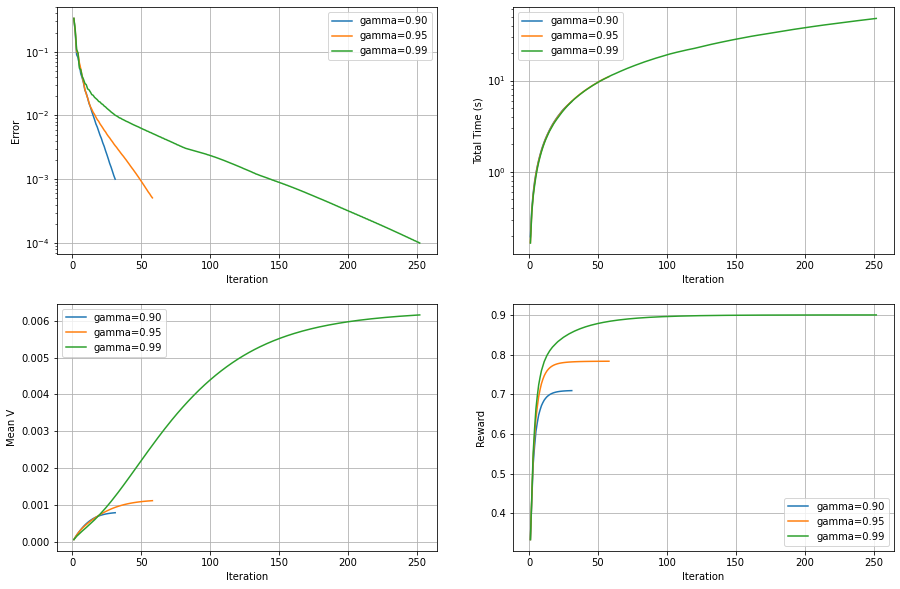

In [11]:
# Value Iteration
_, ax = plt.subplots(2, 2, figsize=(15, 10))

for i in range(3):
    random_map = generate_random_map(size=100, p=0.8)
    P, R = openai("FrozenLake-v1", desc=random_map)
    vi = hiive.mdptoolbox.mdp.ValueIteration(P, R, discounts[i])
    vi.run()

    policy = list(vi.policy)
    
    gamma = discounts[i]

    ax[0][0].semilogy(range(1, vi.iter + 1), [run['Error'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[0][0].set_xlabel('Iteration')
    ax[0][0].set_ylabel('Error')
    ax[0][0].grid()
    ax[0][0].legend()

    ax[0][1].semilogy(range(1, vi.iter + 1), [run['Time'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[0][1].set_xlabel('Iteration')
    ax[0][1].set_ylabel('Total Time (s)')
    ax[0][1].grid()
    ax[0][1].legend()

    ax[1][0].plot(range(1, vi.iter + 1), [run['Mean V'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][0].set_xlabel('Iteration')
    ax[1][0].set_ylabel('Mean V')
    ax[1][0].grid()
    ax[1][0].legend()

    ax[1][1].plot(range(1, vi.iter + 1), [run['Reward'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][1].set_xlabel('Iteration')
    ax[1][1].set_ylabel('Reward')
    ax[1][1].grid()
    ax[1][1].legend()
    
plt.show()

In [12]:
print("Total Time to Implement in Seconds:", vi.time)
print("Total Iterations to Implement:", vi.iter)

Total Time to Implement in Seconds: 47.81414484977722
Total Iterations to Implement: 252


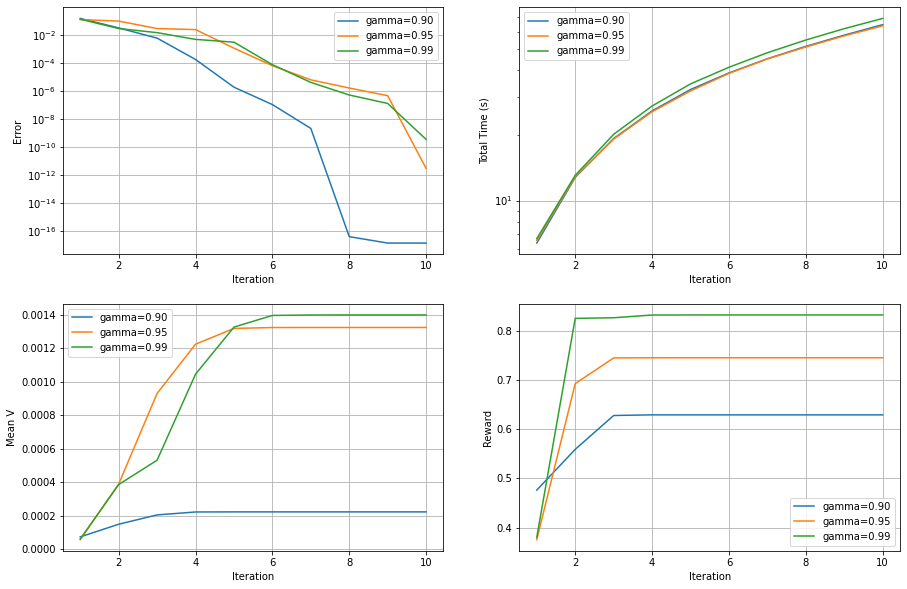

In [13]:
# Policy Iteration
_, ax = plt.subplots(2, 2, figsize=(15, 10))

for i in range(3):
    random_map = generate_random_map(size=100, p=0.8)
    P, R = openai("FrozenLake-v1", desc=random_map)
    pi = hiive.mdptoolbox.mdp.PolicyIteration(P, R, discounts[i], max_iter=10)
    pi.run()

    policy = list(pi.policy)
    
    gamma = discounts[i]

    ax[0][0].semilogy(range(1, pi.iter + 1), [run['Error'] for run in pi.run_stats], label="gamma=%.2f" % gamma)
    ax[0][0].set_xlabel('Iteration')
    ax[0][0].set_ylabel('Error')
    ax[0][0].grid()
    ax[0][0].legend()

    ax[0][1].semilogy(range(1, pi.iter + 1), [run['Time'] for run in pi.run_stats], label="gamma=%.2f" % gamma)
    ax[0][1].set_xlabel('Iteration')
    ax[0][1].set_ylabel('Total Time (s)')
    ax[0][1].grid()
    ax[0][1].legend()

    ax[1][0].plot(range(1, pi.iter + 1), [run['Mean V'] for run in pi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][0].set_xlabel('Iteration')
    ax[1][0].set_ylabel('Mean V')
    ax[1][0].grid()
    ax[1][0].legend()

    ax[1][1].plot(range(1, pi.iter + 1), [run['Reward'] for run in pi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][1].set_xlabel('Iteration')
    ax[1][1].set_ylabel('Reward')
    ax[1][1].grid()
    ax[1][1].legend()
    
plt.show()

In [14]:
print("Total Time to Implement in Seconds:", pi.time)
print("Total Iterations to Implement:", pi.iter)

Total Time to Implement in Seconds: 69.16138696670532
Total Iterations to Implement: 10


## 3) Reinforcement Learning (Another algorithm)
Now pick your favorite reinforcement learning algorithm and use it to solve the two MDPs. How does it perform, especially in comparison to the cases above where you knew the model, rewards, and so on? What exploration strategies did you choose? Did some work better than others?

### Frozen Lake - Q Learning

In [15]:
random_map = generate_random_map(size=10, p=0.98)
env = gym.make("FrozenLake-v1", desc=random_map)
n_observations = env.observation_space.n
n_actions = env.action_space.n

#Initialize the Q-table to 0
Q_table = np.zeros((n_observations,n_actions))

In [16]:
# number of episode we will run
n_episodes = 10000

# maximum of iteration per episode
max_iter_episode = 100

# initialize the exploration probability to 1
exploration_proba = 1

# exploartion decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.001

# minimum of exploration proba
min_exploration_proba = 0.01

# discounted factor
gamma = 0.99

# learning rate
lr = 0.1

total_rewards_episode = list()

In [17]:
start = time.time()

rewards_per_episode = []
# we iterate over episodes
for e in range(n_episodes):
    # we initialize the first state of the episode
    current_state = env.reset()
    done = False
    
    # sum the rewards that the agent gets from the environment
    total_episode_reward = 0
    
    for i in range(max_iter_episode): 
        # we sample a float from a uniform distribution over 0 and 1
        # if the sampled flaot is less than the exploration proba
        #     the agent selects arandom action
        # else
        #     he exploits his knowledge using the bellman equation 
        
        if np.random.uniform(0,1) < exploration_proba:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state,:])
        
        # The environment runs the chosen action and returns
        # the next state, a reward and true if the epiosed is ended.
        next_state, reward, done, _ = env.step(action)
        
        # We update our Q-table using the Q-learning iteration
        Q_table[current_state, action] = (1-lr) * Q_table[current_state, action] +lr*(reward + gamma*max(Q_table[next_state,:]))
        total_episode_reward = total_episode_reward + reward
        # If the episode is finished, we leave the for loop
        if done:
            break
        current_state = next_state
    # We update the exploration proba using exponential decay formula 
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e))
    rewards_per_episode.append(total_episode_reward)
    
end = time.time()

Mean reward per thousand episodes
1000 : mean espiode reward :  0.201
2000 : mean espiode reward :  0.661
3000 : mean espiode reward :  0.843
4000 : mean espiode reward :  0.919
5000 : mean espiode reward :  0.905
6000 : mean espiode reward :  0.939
7000 : mean espiode reward :  0.951
8000 : mean espiode reward :  0.958
9000 : mean espiode reward :  0.947
10000 : mean espiode reward :  0.933


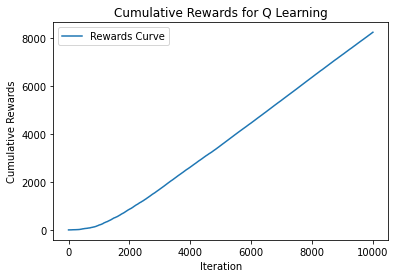

Total Time to Implement in Seconds: 14.885616064071655
Iteration of Convergence: XXXX


In [18]:
print("Mean reward per thousand episodes")
for i in range(10):
    print((i+1)*1000,": mean espiode reward : ", np.mean(rewards_per_episode[1000*i:1000*(i+1)]))
    
q_plot = pd.DataFrame(rewards_per_episode)
q_plot.cumsum().plot()
plt.xlabel("Iteration")
plt.ylabel("Cumulative Rewards")
plt.title("Cumulative Rewards for Q Learning")
plt.legend(["Rewards Curve"])
plt.show()

print("Total Time to Implement in Seconds:", end-start)
print("Iteration of Convergence: XXXX")

### Forest - Q Learning

[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]



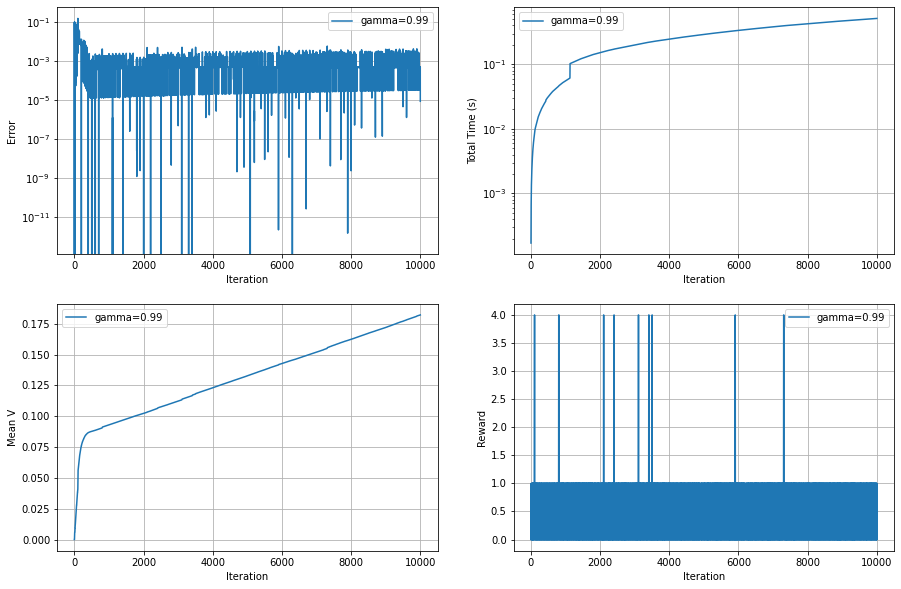

In [19]:
# Q Learning
_, ax = plt.subplots(2, 2, figsize=(15, 10))

P, R = forest()
vi = hiive.mdptoolbox.mdp.QLearning(P, R, 0.99, n_iter=10000)
vi.run()

policy = list(vi.policy)
print(policy)
print()

ax[0][0].semilogy(range(1, 10000 + 1), [run['Error'] for run in vi.run_stats], label="gamma=0.99")
ax[0][0].set_xlabel('Iteration')
ax[0][0].set_ylabel('Error')
ax[0][0].grid()
ax[0][0].legend()

ax[0][1].semilogy(range(1, 10000 + 1), [run['Time'] for run in vi.run_stats], label="gamma=0.99")
ax[0][1].set_xlabel('Iteration')
ax[0][1].set_ylabel('Total Time (s)')
ax[0][1].grid()
ax[0][1].legend()

ax[1][0].plot(range(1, 10000 + 1), [run['Mean V'] for run in vi.run_stats], label="gamma=0.99")
ax[1][0].set_xlabel('Iteration')
ax[1][0].set_ylabel('Mean V')
ax[1][0].grid()
ax[1][0].legend()

ax[1][1].plot(range(1, 10000 + 1), [run['Reward'] for run in vi.run_stats], label="gamma=0.99")
ax[1][1].set_xlabel('Iteration')
ax[1][1].set_ylabel('Reward')
ax[1][1].grid()
ax[1][1].legend()
    
plt.show()

## 4) Further Exploration: Frozen Lake Q Learning
Just a few random explorations (no pun intended) on the frozen lake problem again, since there are so many different parameters...

### LR reduction

Mean reward per thousand episodes
1000 : mean espiode reward :  0.222
2000 : mean espiode reward :  0.652
3000 : mean espiode reward :  0.804
4000 : mean espiode reward :  0.863
5000 : mean espiode reward :  0.87
6000 : mean espiode reward :  0.864
7000 : mean espiode reward :  0.885
8000 : mean espiode reward :  0.868
9000 : mean espiode reward :  0.886
10000 : mean espiode reward :  0.884


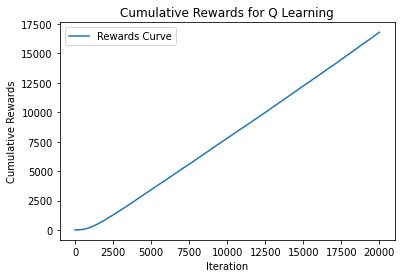

Total Time to Implement in Seconds: 24.86606192588806
Iteration of Convergence: XXXX


In [20]:
random_map = generate_random_map(size=10, p=0.98)
env = gym.make("FrozenLake-v1", desc=random_map)
n_observations = env.observation_space.n
n_actions = env.action_space.n

#Initialize the Q-table to 0
Q_table = np.zeros((n_observations,n_actions))

# number of episode we will run
n_episodes = 20000

# maximum of iteration per episode
max_iter_episode = 100

# initialize the exploration probability to 1
exploration_proba = 1

# exploartion decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.001

# minimum of exploration proba
min_exploration_proba = 0.01

# discounted factor
gamma = 0.99

# learning rate
lr = 0.05

total_rewards_episode = list()

start = time.time()

rewards_per_episode = []
# we iterate over episodes
for e in range(n_episodes):
    # we initialize the first state of the episode
    current_state = env.reset()
    done = False
    
    # sum the rewards that the agent gets from the environment
    total_episode_reward = 0
    
    for i in range(max_iter_episode): 
        # we sample a float from a uniform distribution over 0 and 1
        # if the sampled flaot is less than the exploration proba
        #     the agent selects arandom action
        # else
        #     he exploits his knowledge using the bellman equation 
        
        if np.random.uniform(0,1) < exploration_proba:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state,:])
        
        # The environment runs the chosen action and returns
        # the next state, a reward and true if the epiosed is ended.
        next_state, reward, done, _ = env.step(action)
        
        # We update our Q-table using the Q-learning iteration
        Q_table[current_state, action] = (1-lr) * Q_table[current_state, action] +lr*(reward + gamma*max(Q_table[next_state,:]))
        total_episode_reward = total_episode_reward + reward
        # If the episode is finished, we leave the for loop
        if done:
            break
        current_state = next_state
    # We update the exploration proba using exponential decay formula 
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e))
    rewards_per_episode.append(total_episode_reward)
    
end = time.time()

print("Mean reward per thousand episodes")
for i in range(10):
    print((i+1)*1000,": mean espiode reward : ", np.mean(rewards_per_episode[1000*i:1000*(i+1)]))
    
q_plot = pd.DataFrame(rewards_per_episode)
q_plot.cumsum().plot()
plt.xlabel("Iteration")
plt.ylabel("Cumulative Rewards")
plt.title("Cumulative Rewards for Q Learning")
plt.legend(["Rewards Curve"])
plt.show()

print("Total Time to Implement in Seconds:", end-start)
print("Iteration of Convergence: XXXX")

### LR Boost

Mean reward per thousand episodes
1000 : mean espiode reward :  0.262
2000 : mean espiode reward :  0.638
3000 : mean espiode reward :  0.861
4000 : mean espiode reward :  0.894
5000 : mean espiode reward :  0.943
6000 : mean espiode reward :  0.943
7000 : mean espiode reward :  0.953
8000 : mean espiode reward :  0.933
9000 : mean espiode reward :  0.952
10000 : mean espiode reward :  0.936


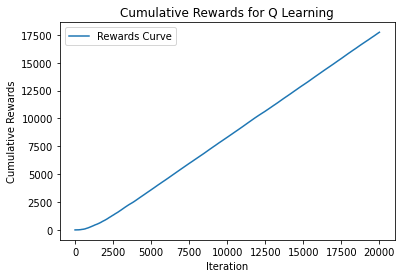

Total Time to Implement in Seconds: 24.675049781799316
Iteration of Convergence: XXXX


In [21]:
random_map = generate_random_map(size=10, p=0.98)
env = gym.make("FrozenLake-v1", desc=random_map)
n_observations = env.observation_space.n
n_actions = env.action_space.n

#Initialize the Q-table to 0
Q_table = np.zeros((n_observations,n_actions))

# number of episode we will run
n_episodes = 20000

# maximum of iteration per episode
max_iter_episode = 100

# initialize the exploration probability to 1
exploration_proba = 1

# exploartion decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.001

# minimum of exploration proba
min_exploration_proba = 0.01

# discounted factor
gamma = 0.99

# learning rate
lr = 0.2

total_rewards_episode = list()

start = time.time()

rewards_per_episode = []
# we iterate over episodes
for e in range(n_episodes):
    # we initialize the first state of the episode
    current_state = env.reset()
    done = False
    
    # sum the rewards that the agent gets from the environment
    total_episode_reward = 0
    
    for i in range(max_iter_episode): 
        # we sample a float from a uniform distribution over 0 and 1
        # if the sampled flaot is less than the exploration proba
        #     the agent selects arandom action
        # else
        #     he exploits his knowledge using the bellman equation 
        
        if np.random.uniform(0,1) < exploration_proba:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state,:])
        
        # The environment runs the chosen action and returns
        # the next state, a reward and true if the epiosed is ended.
        next_state, reward, done, _ = env.step(action)
        
        # We update our Q-table using the Q-learning iteration
        Q_table[current_state, action] = (1-lr) * Q_table[current_state, action] +lr*(reward + gamma*max(Q_table[next_state,:]))
        total_episode_reward = total_episode_reward + reward
        # If the episode is finished, we leave the for loop
        if done:
            break
        current_state = next_state
    # We update the exploration proba using exponential decay formula 
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e))
    rewards_per_episode.append(total_episode_reward)
    
end = time.time()

print("Mean reward per thousand episodes")
for i in range(10):
    print((i+1)*1000,": mean espiode reward : ", np.mean(rewards_per_episode[1000*i:1000*(i+1)]))
    
q_plot = pd.DataFrame(rewards_per_episode)
q_plot.cumsum().plot()
plt.xlabel("Iteration")
plt.ylabel("Cumulative Rewards")
plt.title("Cumulative Rewards for Q Learning")
plt.legend(["Rewards Curve"])
plt.show()

print("Total Time to Implement in Seconds:", end-start)
print("Iteration of Convergence: XXXX")

### Decay Increase

Mean reward per thousand episodes
1000 : mean espiode reward :  0.002
2000 : mean espiode reward :  0.0
3000 : mean espiode reward :  0.0
4000 : mean espiode reward :  0.0
5000 : mean espiode reward :  0.0
6000 : mean espiode reward :  0.0
7000 : mean espiode reward :  0.0
8000 : mean espiode reward :  0.0
9000 : mean espiode reward :  0.0
10000 : mean espiode reward :  0.0


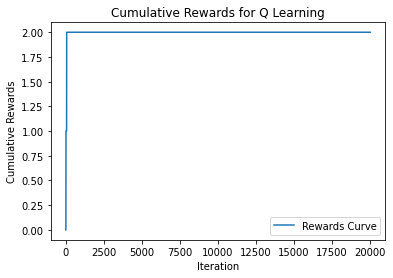

Total Time to Implement in Seconds: 40.46052002906799
Iteration of Convergence: XXXX


In [22]:
random_map = generate_random_map(size=10, p=0.98)
env = gym.make("FrozenLake-v1", desc=random_map)
n_observations = env.observation_space.n
n_actions = env.action_space.n

#Initialize the Q-table to 0
Q_table = np.zeros((n_observations,n_actions))

# number of episode we will run
n_episodes = 20000

# maximum of iteration per episode
max_iter_episode = 100

# initialize the exploration probability to 1
exploration_proba = 1

# exploartion decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.008

# minimum of exploration proba
min_exploration_proba = 0.01

# discounted factor
gamma = 0.99

# learning rate
lr = 0.1

total_rewards_episode = list()

start = time.time()

rewards_per_episode = []
# we iterate over episodes
for e in range(n_episodes):
    # we initialize the first state of the episode
    current_state = env.reset()
    done = False
    
    # sum the rewards that the agent gets from the environment
    total_episode_reward = 0
    
    for i in range(max_iter_episode): 
        # we sample a float from a uniform distribution over 0 and 1
        # if the sampled flaot is less than the exploration proba
        #     the agent selects arandom action
        # else
        #     he exploits his knowledge using the bellman equation 
        
        if np.random.uniform(0,1) < exploration_proba:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state,:])
        
        # The environment runs the chosen action and returns
        # the next state, a reward and true if the epiosed is ended.
        next_state, reward, done, _ = env.step(action)
        
        # We update our Q-table using the Q-learning iteration
        Q_table[current_state, action] = (1-lr) * Q_table[current_state, action] +lr*(reward + gamma*max(Q_table[next_state,:]))
        total_episode_reward = total_episode_reward + reward
        # If the episode is finished, we leave the for loop
        if done:
            break
        current_state = next_state
    # We update the exploration proba using exponential decay formula 
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e))
    rewards_per_episode.append(total_episode_reward)
    
end = time.time()

print("Mean reward per thousand episodes")
for i in range(10):
    print((i+1)*1000,": mean espiode reward : ", np.mean(rewards_per_episode[1000*i:1000*(i+1)]))
    
q_plot = pd.DataFrame(rewards_per_episode)
q_plot.cumsum().plot()
plt.xlabel("Iteration")
plt.ylabel("Cumulative Rewards")
plt.title("Cumulative Rewards for Q Learning")
plt.legend(["Rewards Curve"])
plt.show()

print("Total Time to Implement in Seconds:", end-start)
print("Iteration of Convergence: XXXX")

### Decay Decrease

Mean reward per thousand episodes
1000 : mean espiode reward :  0.082
2000 : mean espiode reward :  0.078
3000 : mean espiode reward :  0.071
4000 : mean espiode reward :  0.063
5000 : mean espiode reward :  0.079
6000 : mean espiode reward :  0.095
7000 : mean espiode reward :  0.092
8000 : mean espiode reward :  0.096
9000 : mean espiode reward :  0.092
10000 : mean espiode reward :  0.111


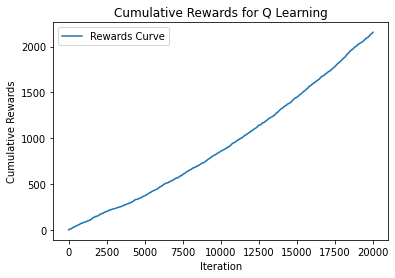

Total Time to Implement in Seconds: 57.8222770690918
Iteration of Convergence: XXXX


In [23]:
random_map = generate_random_map(size=10, p=0.98)
env = gym.make("FrozenLake-v1", desc=random_map)
n_observations = env.observation_space.n
n_actions = env.action_space.n

#Initialize the Q-table to 0
Q_table = np.zeros((n_observations,n_actions))

# number of episode we will run
n_episodes = 20000

# maximum of iteration per episode
max_iter_episode = 100

# initialize the exploration probability to 1
exploration_proba = 1

# exploartion decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.00001

# minimum of exploration proba
min_exploration_proba = 0.01

# discounted factor
gamma = 0.99

# learning rate
lr = 0.1

total_rewards_episode = list()

start = time.time()

rewards_per_episode = []
# we iterate over episodes
for e in range(n_episodes):
    # we initialize the first state of the episode
    current_state = env.reset()
    done = False
    
    # sum the rewards that the agent gets from the environment
    total_episode_reward = 0
    
    for i in range(max_iter_episode): 
        # we sample a float from a uniform distribution over 0 and 1
        # if the sampled flaot is less than the exploration proba
        #     the agent selects arandom action
        # else
        #     he exploits his knowledge using the bellman equation 
        
        if np.random.uniform(0,1) < exploration_proba:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state,:])
        
        # The environment runs the chosen action and returns
        # the next state, a reward and true if the epiosed is ended.
        next_state, reward, done, _ = env.step(action)
        
        # We update our Q-table using the Q-learning iteration
        Q_table[current_state, action] = (1-lr) * Q_table[current_state, action] +lr*(reward + gamma*max(Q_table[next_state,:]))
        total_episode_reward = total_episode_reward + reward
        # If the episode is finished, we leave the for loop
        if done:
            break
        current_state = next_state
    # We update the exploration proba using exponential decay formula 
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e))
    rewards_per_episode.append(total_episode_reward)
    
end = time.time()

print("Mean reward per thousand episodes")
for i in range(10):
    print((i+1)*1000,": mean espiode reward : ", np.mean(rewards_per_episode[1000*i:1000*(i+1)]))
    
q_plot = pd.DataFrame(rewards_per_episode)
q_plot.cumsum().plot()
plt.xlabel("Iteration")
plt.ylabel("Cumulative Rewards")
plt.title("Cumulative Rewards for Q Learning")
plt.legend(["Rewards Curve"])
plt.show()

print("Total Time to Implement in Seconds:", end-start)
print("Iteration of Convergence: XXXX")

### Triple min_exploration_proba

Mean reward per thousand episodes
1000 : mean espiode reward :  0.075
2000 : mean espiode reward :  0.066
3000 : mean espiode reward :  0.091
4000 : mean espiode reward :  0.085
5000 : mean espiode reward :  0.079
6000 : mean espiode reward :  0.084
7000 : mean espiode reward :  0.086
8000 : mean espiode reward :  0.086
9000 : mean espiode reward :  0.085
10000 : mean espiode reward :  0.093


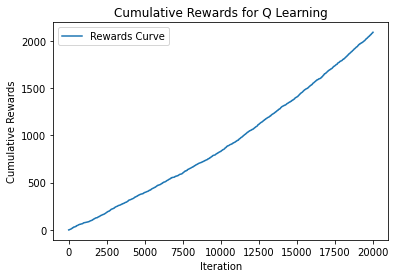

Total Time to Implement in Seconds: 57.63023400306702
Iteration of Convergence: XXXX


In [24]:
random_map = generate_random_map(size=10, p=0.98)
env = gym.make("FrozenLake-v1", desc=random_map)
n_observations = env.observation_space.n
n_actions = env.action_space.n

#Initialize the Q-table to 0
Q_table = np.zeros((n_observations,n_actions))

# number of episode we will run
n_episodes = 20000

# maximum of iteration per episode
max_iter_episode = 100

# initialize the exploration probability to 1
exploration_proba = 1

# exploartion decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.00001

# minimum of exploration proba
min_exploration_proba = 0.03

# discounted factor
gamma = 0.99

# learning rate
lr = 0.1

total_rewards_episode = list()

start = time.time()

rewards_per_episode = []
# we iterate over episodes
for e in range(n_episodes):
    # we initialize the first state of the episode
    current_state = env.reset()
    done = False
    
    # sum the rewards that the agent gets from the environment
    total_episode_reward = 0
    
    for i in range(max_iter_episode): 
        # we sample a float from a uniform distribution over 0 and 1
        # if the sampled flaot is less than the exploration proba
        #     the agent selects arandom action
        # else
        #     he exploits his knowledge using the bellman equation 
        
        if np.random.uniform(0,1) < exploration_proba:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state,:])
        
        # The environment runs the chosen action and returns
        # the next state, a reward and true if the epiosed is ended.
        next_state, reward, done, _ = env.step(action)
        
        # We update our Q-table using the Q-learning iteration
        Q_table[current_state, action] = (1-lr) * Q_table[current_state, action] +lr*(reward + gamma*max(Q_table[next_state,:]))
        total_episode_reward = total_episode_reward + reward
        # If the episode is finished, we leave the for loop
        if done:
            break
        current_state = next_state
    # We update the exploration proba using exponential decay formula 
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e))
    rewards_per_episode.append(total_episode_reward)
    
end = time.time()

print("Mean reward per thousand episodes")
for i in range(10):
    print((i+1)*1000,": mean espiode reward : ", np.mean(rewards_per_episode[1000*i:1000*(i+1)]))
    
q_plot = pd.DataFrame(rewards_per_episode)
q_plot.cumsum().plot()
plt.xlabel("Iteration")
plt.ylabel("Cumulative Rewards")
plt.title("Cumulative Rewards for Q Learning")
plt.legend(["Rewards Curve"])
plt.show()

print("Total Time to Implement in Seconds:", end-start)
print("Iteration of Convergence: XXXX")

***Models on these MDPs FINISHED***